In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vishnu@02',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/user/OneDrive/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [ ]:
pip install seaborn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vishnu@02',
    database='ecommerce')

cur = db.cursor()




### 1. List all unique cities where customers are located.

In [2]:
query =""" select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [3]:
query =""" select count(order_id) from orders where year(order_purchase_timestamp)= 2017"""

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are ", data[0][0]

('Total orders placed in 2017 are ', 90202)

# 3. Find the total sales per category.


In [4]:
query = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data,columns =["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# 4. Calculate the percentage of orders that were paid in installments.


In [5]:
query =""" select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"percentage of orders that were paid in installments",data[0][0]

('percentage of orders that were paid in installments', Decimal('99.9981'))

# 5. Count the number of customers from each state. 


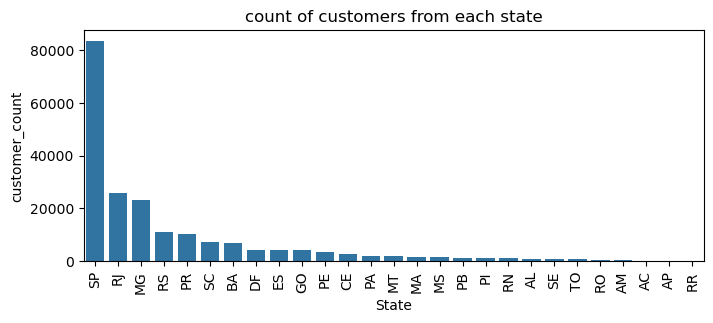

In [6]:
query =""" select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State","customer_count"])
df=df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (8,3))
sns.barplot(x=df["State"],y=df["customer_count"])
plt.xticks(rotation = 90)
plt.title("count of customers from each state")

plt.show()

# Intermediate Queries

# 1. Calculate the number of orders per month in 2018.

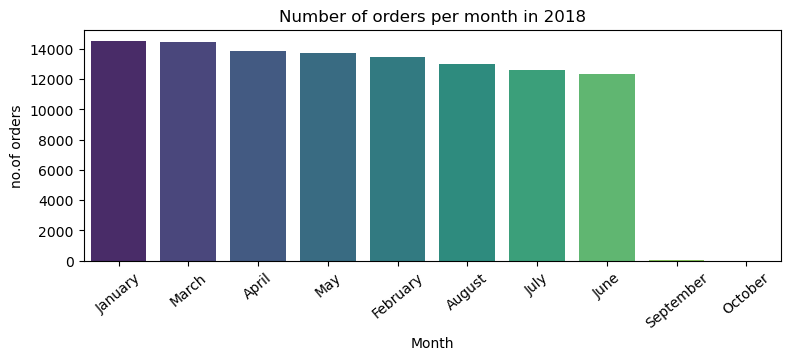

In [7]:
query = """ select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall() 
df = pd.DataFrame(data, columns = ["Month","no.of orders"])
df=df.sort_values(by = "no.of orders", ascending = False)
plt.figure(figsize = (9,3))
plt.xticks(rotation = 40)
plt.title("Number of orders per month in 2018")
sns.barplot(x=df["Month"],y=df["no.of orders"],hue= df["Month"],palette="viridis")
plt.show()


# 2. Find the average number of products per order, grouped by customer city.


In [8]:
query =""" with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders
"""

cur.execute(query)

data = cur.fetchall()
df= pd.DataFrame(data ,columns=["customer city","average orders"])
df.head(5)
# plt.figure(figsize = (9,3))
# plt.xticks(rotation = 40)
# sns.barplot(x=df["customer city"],y=df["average orders"],hue= df["customer city"],palette="viridis")
# plt.show()

,customer city,average orders
0,cairu,2.00
1,epitaciolandia,2.00
2,urucania,2.00
3,brotas de macaubas,2.00
4,tunapolis,2.00


# 3. Calculate the percentage of total revenue contributed by each product category.


In [9]:
query = """select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc """


cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data ,columns=["Category","Percentage distribution"])
df.head(10)

,Category,Percentage distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


# 4. Identify the correlation between product price and the number of times a product has been purchased.


In [10]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """


cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data ,columns=["Category","order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a=np.corrcoef([arr1,arr2])

print("the correlation between product price and the number of times a product has been purchased is ",a[0][1])

the correlation between product price and the number of times a product has been purchased is  -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.


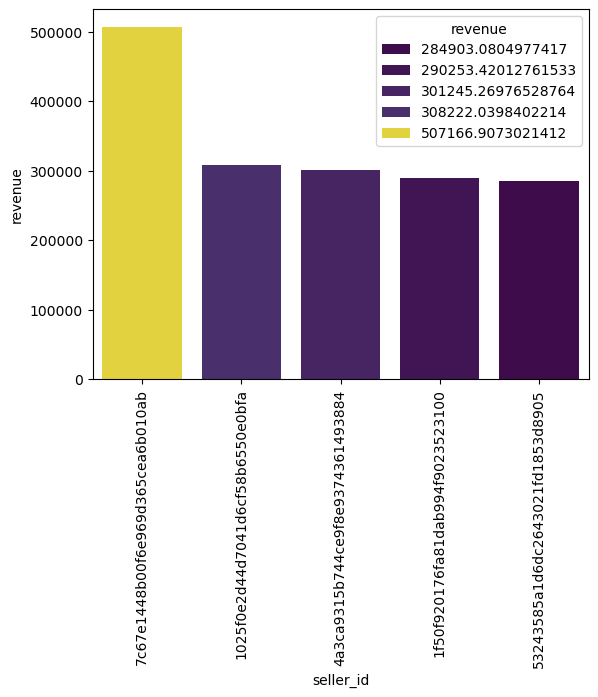

In [11]:
query = """ select *, dense_rank() over(order by revenue desc) as en from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)as a
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
df= df.head()
plt.xticks(rotation = 90)
sns.barplot(x=df["seller_id"],y = df ["revenue"],hue= df["revenue"],palette="viridis")
plt.show()

# Advanced Queries
# 1. Calculate the moving average of order values for each customer over their order history.

In [12]:
query = """ select customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg
from

(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id","order_purchase_timestam","payment","mov avg"])
df= df.head()
df

,customer_id,order_purchase_timestam,payment,mov avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998


# 2. Calculate the cumulative sales per month for each year.


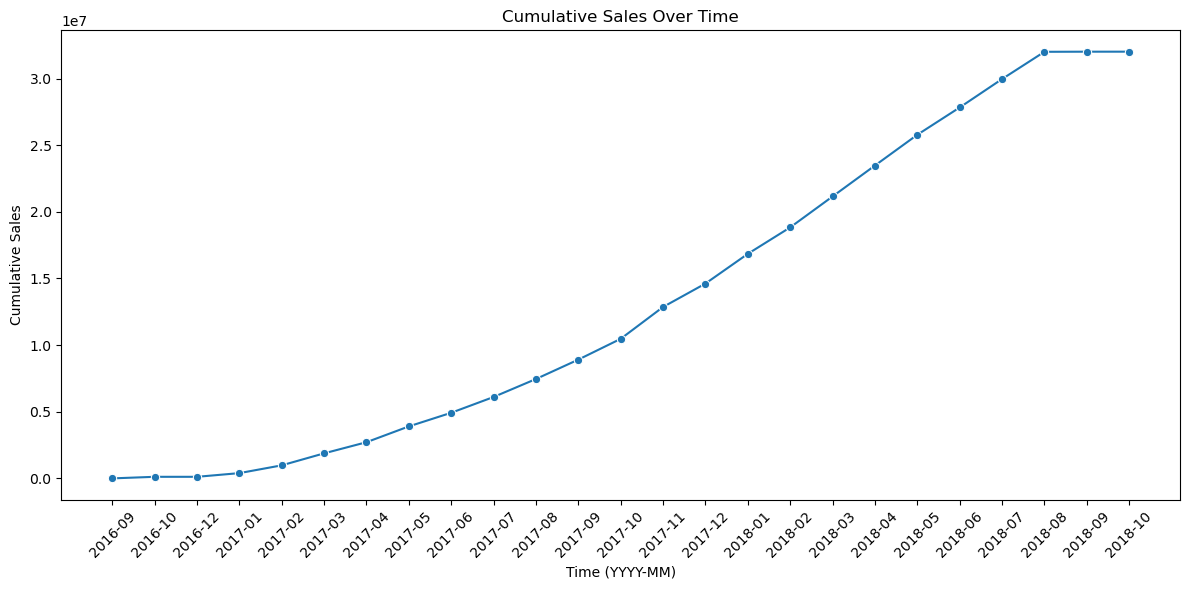

In [13]:
query = """ select years, months, payment, sum(payment)
over(order by years, months) cumulativesales from
(select year(orders.order_purchase_timestamp)as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years , months) as a;
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","months","payment","cumulativesales"])
df= df.head(25)
df["time"] = df["years"].astype(str) + "-" + df["months"].astype(str).str.zfill(2)

plt.figure(figsize=(12, 6))
sns.lineplot(x="time", y="cumulativesales", data=df, marker="o")
plt.title("Cumulative Sales Over Time")
plt.xlabel("Time (YYYY-MM)")
plt.ylabel("Cumulative Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Calculate the year-over-year growth rate of total sales.


In [14]:
query = """with a as (select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years, ((payment- lag(payment, 1) over(order by years))/ lag(payment, 1) over(order by years))*100 from a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns =['years','yoy % growth'])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [15]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) nexr_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp> first_order
and orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100* (count(distinct a.customer_id)/count(distinct(b.customer_id)))
from a left join b
on a.customer_id = b. customer_id"""

cur.execute(query)

data = cur.fetchall()
data

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

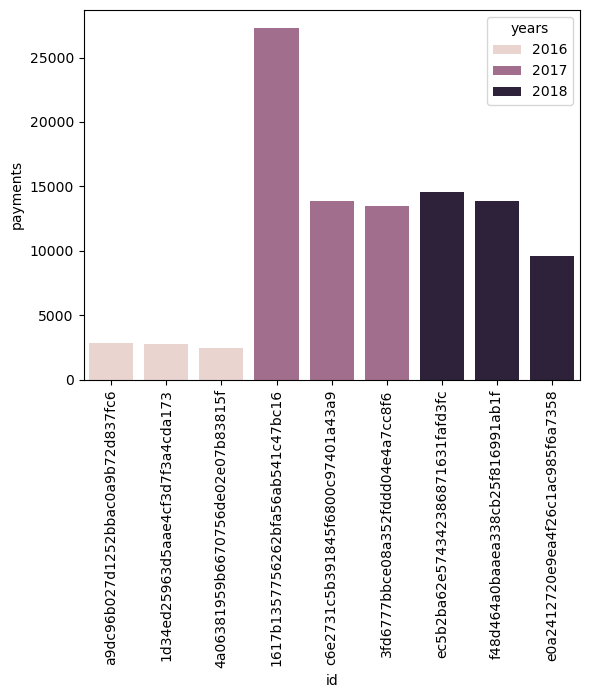

In [16]:
query = """select years, customer_id, payment, d_rank
from 
(select year(orders.order_purchase_timestamp)years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by orders.order_purchase_timestamp,
orders.customer_id) as a 
where d_rank <=3"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns =['years','id','payments','rank'])
sns.barplot(x="id",y="payments", data= df, hue= "years")
plt.xticks(rotation=90)
